# Insurance Cost Prediction based on Patient's Health and Age

**Objective:** In this capstone project, the primary aim is to predict insurance cost based on information of the patients. This can help insurance companies and individuals to help predict and plan for insurance costs considering the various health factors.

1. [Data Exploration](#data)
2. [Data Transformation](#dt)
3. [Clustering](#clustering)
4. [Model Training](#train)
5. [Hyperparameter Tuning](#hyper)
6. [Final Results and Conclusion](#final-results)
7. [Findings](#findings)
8. [Reference](#reference)

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from prettytable import PrettyTable 

# clustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# model building & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, learning_curve

#Handle Warnings
import warnings
warnings.filterwarnings("ignore")

# THE DATA:<a id="data"></a>

This dataset contains 1338 rows of insured data, where the Insurance charges are given against the following attributes of the insured: Age, Sex, BMI, Number of Children, Smoker and Region. The attributes are a mix of numeric and categorical variables.

In [2]:
df = pd.read_csv(r"./data/insurance.csv")
df.drop_duplicates(keep="first",inplace=True)
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
1025,21,female,34.600,0,no,southwest,2020.17700
5,31,female,25.740,0,no,southeast,3756.62160
1201,46,male,40.375,2,no,northwest,8733.22925
747,19,male,21.755,0,no,northwest,1627.28245
567,41,male,30.590,2,no,northwest,7256.72310


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


&emsp;**Analysis:** There are no missing values, so we don't need to fill in the missing values, but there are number variables and categorical variables, so we need to encode them to run the regression.

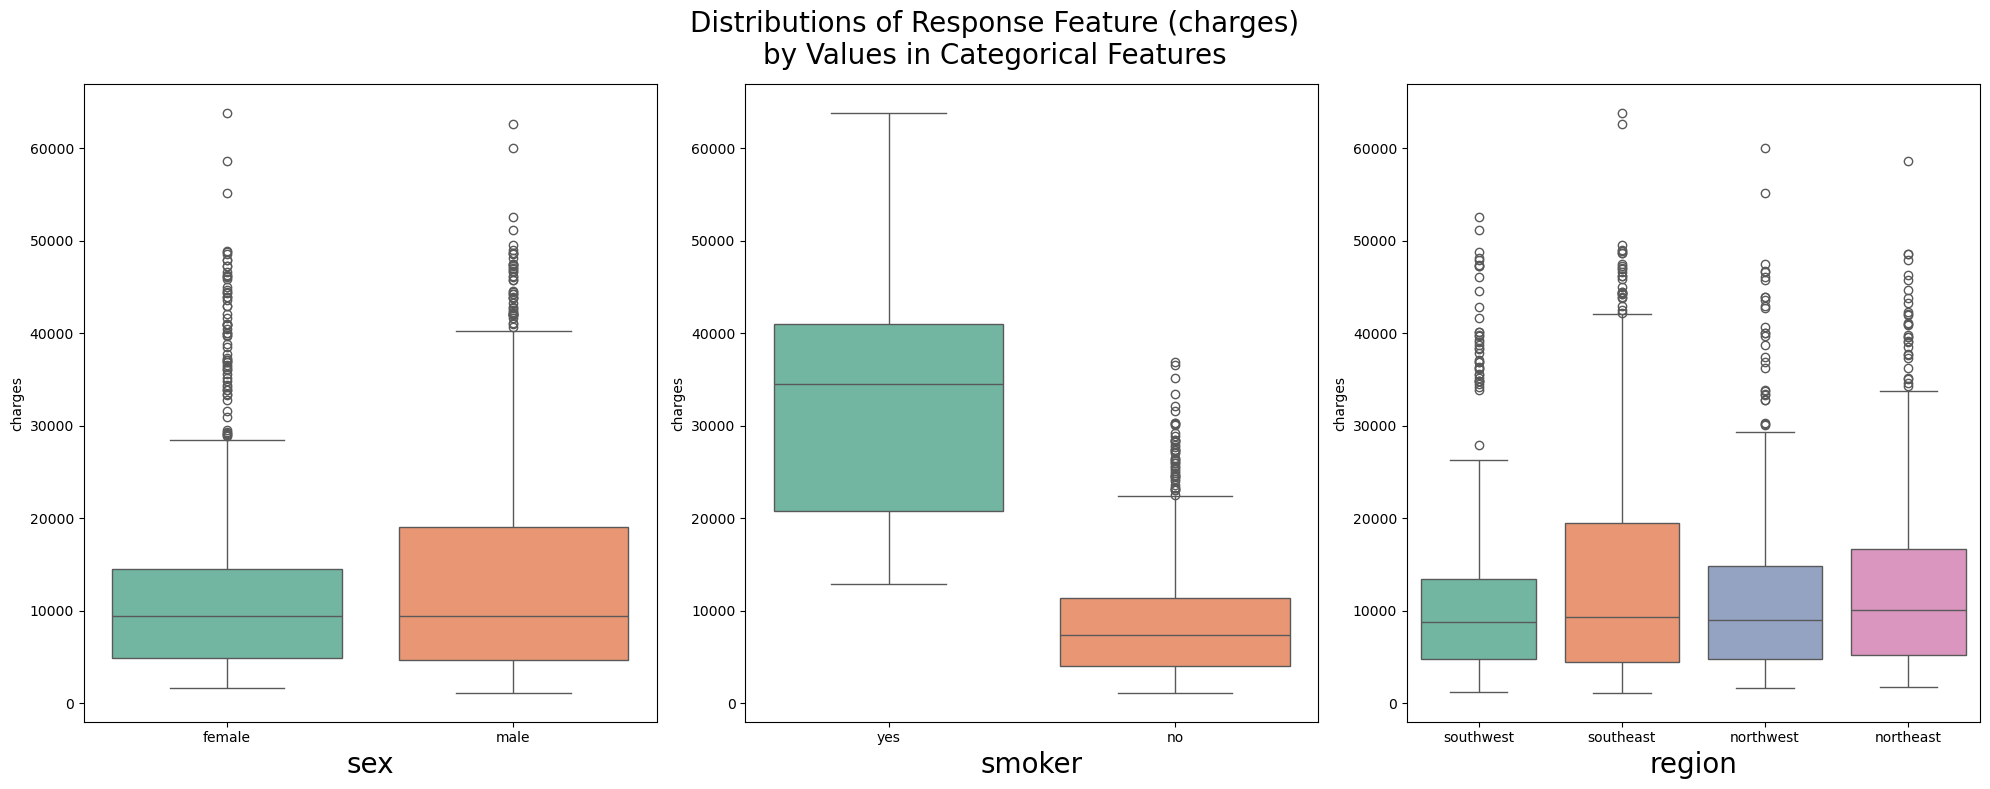

In [4]:
# Boxplots for categorical features
fig = plt.figure(figsize=(20,8))
for i, feature in enumerate(df.select_dtypes(include=object).columns):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(df, x=feature, y='charges', hue=feature, palette=sns.color_palette('Set2', n_colors=len(df[feature].value_counts().index)), ax=ax)
    ax.set_xlabel(feature, fontsize=20)
fig.suptitle("Distributions of Response Feature (charges)\nby Values in Categorical Features", fontsize=20)
fig.tight_layout()
plt.show()

&emsp;**Analysis:** Simply looking at the distributions from the boxplots, there is a clear difference in the distributions of medical costs between smokers and non-smokers. Thus, **smoker** seems to be a promising feature for the training the model. Apart from this apparent difference, people who are males in **sex** seems to have higher medical costs in general.

# DATA TRANSFORMATION: <a id='dt'></a>
Transforming the whole data to numeric values. 

In [5]:
#ordinal encoding
enc_data = df.copy(deep=True)

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

enc.fit(enc_data["sex"])
enc_data["sex"] = enc.transform(enc_data["sex"])

enc.fit(enc_data["smoker"])
enc_data["smoker"] = enc.transform(enc_data["smoker"])

enc.fit(enc_data["region"])
enc_data["region"] = enc.transform(enc_data["region"])

enc_data.sample(5)

,age,sex,bmi,children,smoker,region,charges
1165,35,0,26.125,0,0,0,5227.98875
141,26,1,32.490,1,0,0,3490.54910
1039,19,1,27.265,2,0,1,22493.65964
1207,36,1,33.400,2,1,3,38415.47400
122,20,0,28.975,0,0,1,2257.47525


In [6]:
# Convert categorical features as dummy variables
data = pd.get_dummies(df, dtype=int)
# Rearrange response variable to the last column
y = data['charges']
data = data.drop(columns=['charges'])
data = pd.concat([data, y], axis=1)
data.head(2)

data.sample(5)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges
1248,18,39.820,0,1,0,1,0,0,0,1,0,1633.96180
656,26,42.400,1,1,0,1,0,0,0,0,1,3410.32400
491,61,25.080,0,1,0,1,0,0,0,1,0,24513.09126
1264,49,33.345,2,1,0,1,0,1,0,0,0,10370.91255
595,46,33.725,1,1,0,1,0,1,0,0,0,8823.98575


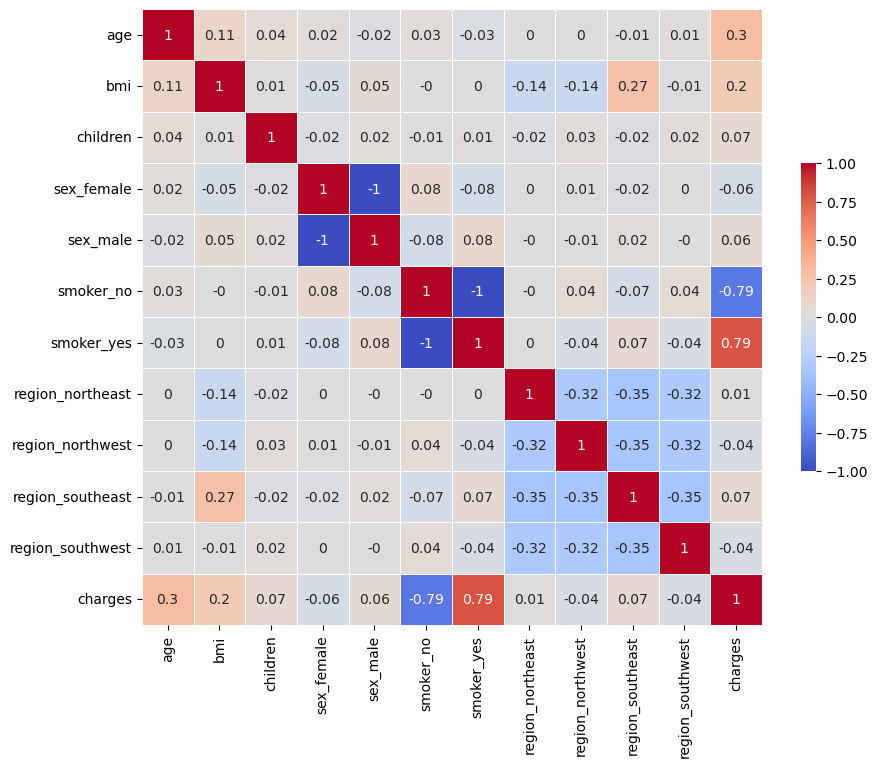

In [7]:
cor = round(data.corr(), 2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cor, cmap='coolwarm', annot=True, vmin=-1, vmax=1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
ax.grid(False)
plt.show()

&emsp;**Analysis:** By looking at the last row of the plot, number of children, sex, and region indicate insignificant relationship with the response variable, medical cost. The most significant pearson coefficients are shown in both the **smoker** dummy variables. One of them will be used to train the model. **Age** and **bmi** will also be considered in the process as they showed some correlation with the response variable. Further visualization will be done to examine and confirm the significance of the linear relationship.

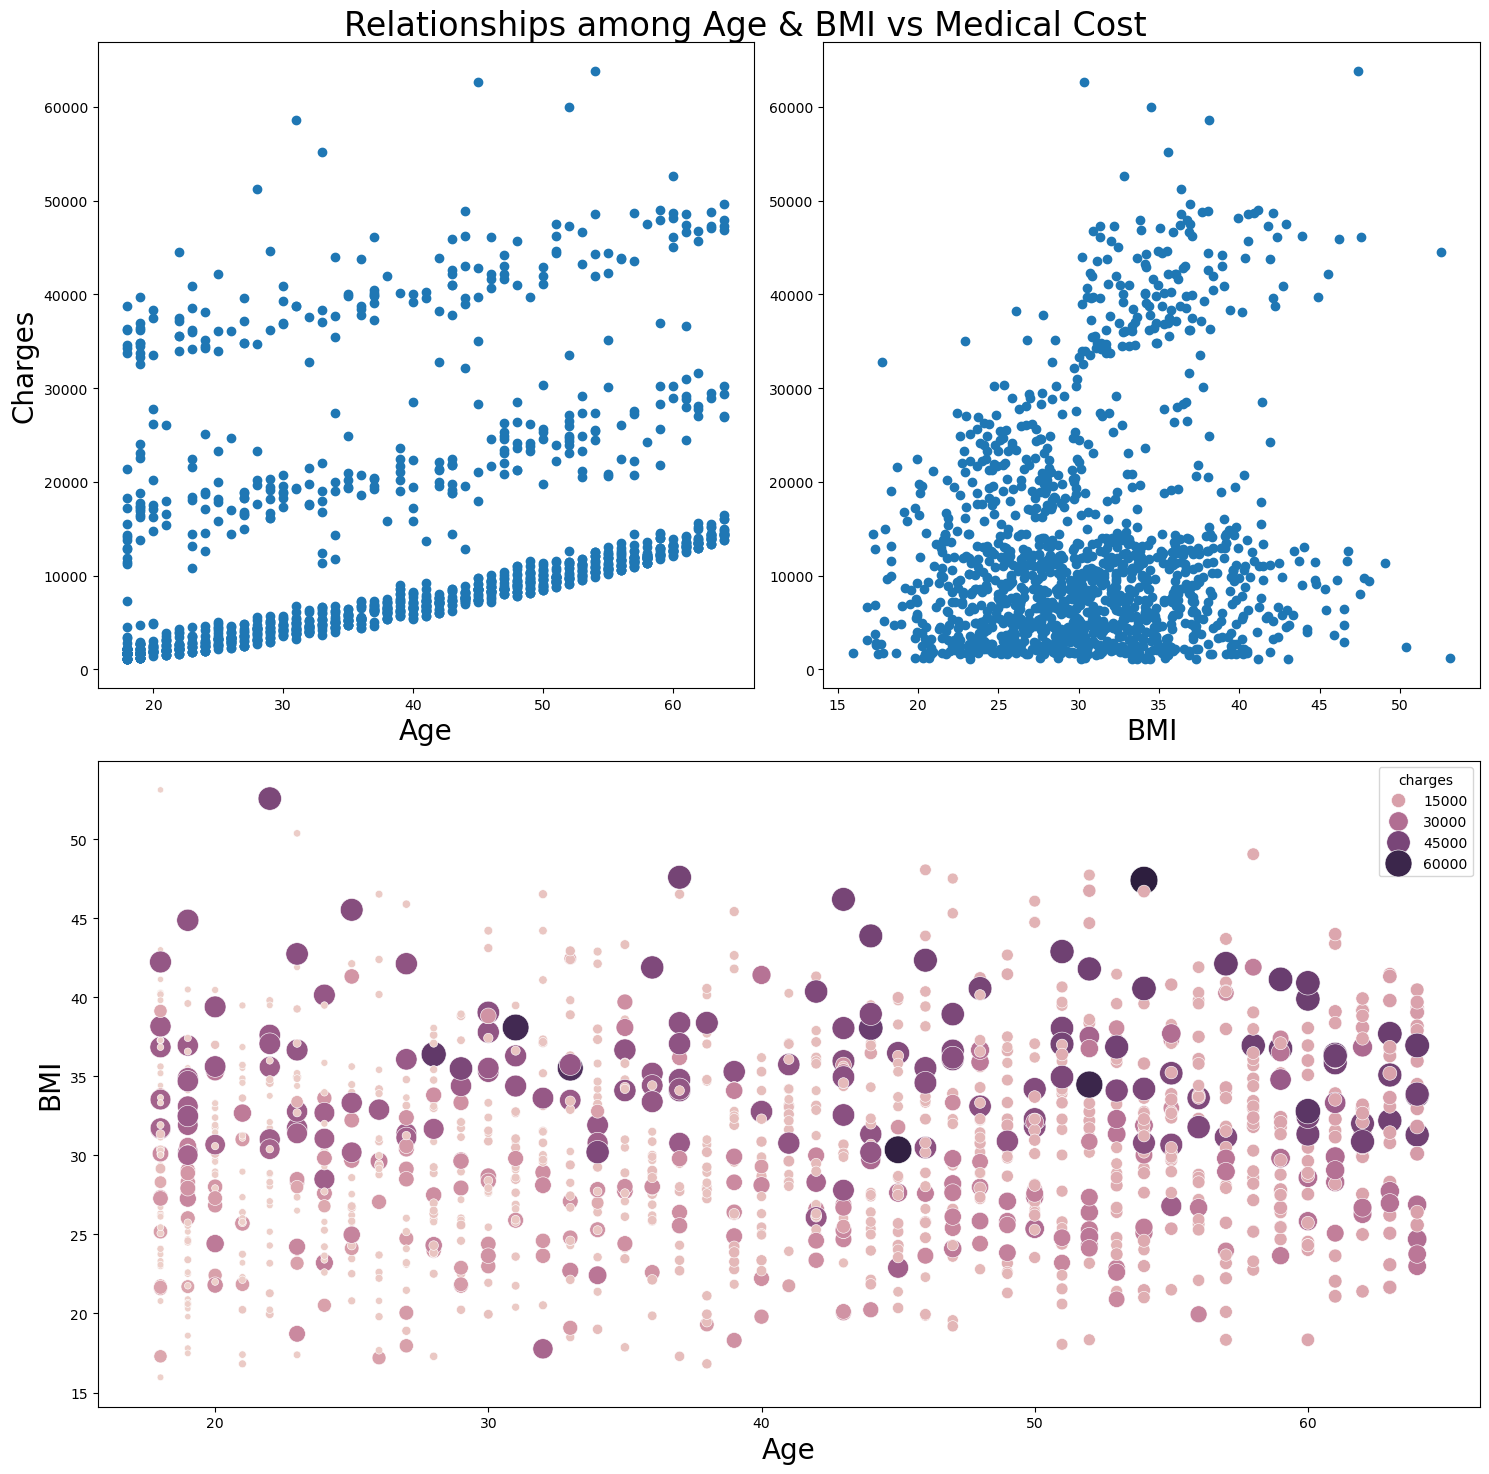

In [8]:
# Scatterplots for age and bmi versus charges
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(data=data, x='age', y='charges')
ax1.set_xlabel('Age', fontsize=20)
ax1.set_ylabel('Charges', fontsize=20)

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(data=data, x='bmi', y='charges')
ax2.set_xlabel('BMI', fontsize=20)

ax3 = fig.add_subplot(2,1,2)
sns.scatterplot(data=data, x='age', y='bmi', size='charges', sizes=(20,400), hue='charges', ax=ax3)
ax3.legend(title='charges', loc='best')
ax3.set_xlabel('Age', fontsize=20)
ax3.set_ylabel('BMI', fontsize=20)

fig.suptitle("Relationships among Age & BMI vs Medical Cost", fontsize=24)
fig.tight_layout()
plt.show()

&emsp;**Analysis:** Simply looking at the relationships from the scatterplots, **BMI** does not show apparent linear relationship with charges. **Age** shows a positive relationship with charges; however, there is quite a wide variance in charges. Apparently, there are 3 trendlines in the plot. There may be another crucial feature(s) segmenting people into these 3 groups. As a result, before **Age** and **Smoker** are used to train the model, DBSCAN and Gaussian Mixture Model will be used to cluster the people into desirably 3 groups.<a id='charges-age'></a><a id='bmi'></a>

# CLUSTERING: <a id='clustering'></a>
Analyzing the data in the form of clusters using GMM and DBSCAN Techniques

In [9]:
# Scale features for DBSCAN 
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(data[['age','charges']]), columns=[['age','charges']])
# DBSCAN
db = DBSCAN()
clusters_db = db.fit_predict(scaled)
np.unique(clusters_db)

array([-1,  0])

In [10]:
# Gaussian Mixture Modelling 
gm = GaussianMixture(n_components=3)
clusters_gm = gm.fit_predict(data[['age','charges']])
np.unique(clusters_gm)

array([0, 1, 2])

&emsp;**Analysis:** DBSCAN and Gaussian Mixture Model (GMM) clustering algorthms were used. DBSCAN auto discovers the number of clusters based on density whereas GMM is a distance based probabilistic model where covariance structure is taken into account (Baruah 2020). The number of clusters, 3, is chosen for GMM clustering based on the [visualization](#charges-age). DBSCSAN, on the other hand, detected 2 clusters. The relationship between **Age** and **Charges** are displayed again with the labels from the clustering algorithms.

In [11]:
data['db'] = clusters_db + 1
data['gm'] = clusters_gm

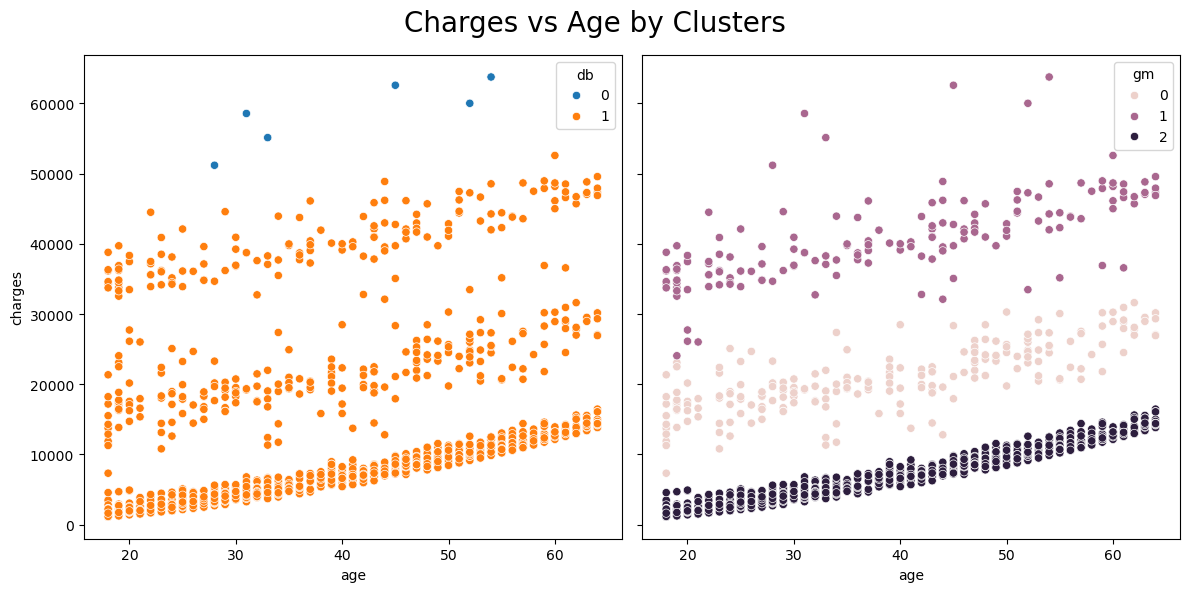

In [12]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x="age", y="charges", hue="db", data=data, ax=ax1)

ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x="age", y="charges", hue="gm", data=data, ax=ax2)
ax2.set_ylabel("")
ax2.set_yticklabels([])

fig.suptitle("Charges vs Age by Clusters", fontsize=20)
fig.tight_layout()
plt.show()

&emsp;**Analysis:** **DBSCAN**, in this case, was only able to separate the scattered outliers from the three main trendlines. On the other hand, the **GMM** algorithm managed to label the data points from the trendlines into 3 clusters. Thus, the labels from **GMM** will be used for model training. Before training, the labels are conveted into dummy variables due to their nominal characteristic.

In [13]:
data.drop(columns=['db'], inplace=True)
data = pd.get_dummies(data, columns=['gm'], drop_first=True, dtype=int)
data.head(2)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges,gm_1,gm_2
0,19,27.90,0,1,0,0,1,0,0,0,1,16884.9240,0,0
1,18,33.77,1,0,1,1,0,0,0,1,0,1725.5523,0,1


# Model Training<a id='train'></a>

In [14]:
# Predictors and response variable
X = data.drop(columns=['charges'])
y = data['charges']
# Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=4)

**Analysis:** The regression related task models will be evaluated using two key metrics: RMSE and R2. 
**RMSE** gives us a sense of how far off the model's predictions are from the actual values—the lower the RMSE, the better. 
**R2** the coefficient of determination, tells us what proportion of the target variable's variance is explained by the model. An R2 closer to 1 indicates a stronger model.

<font size=5><p style="color:blue"> Linear Regression (Baseline Model)

In [15]:
# Fitting training data
# Baseline Model - Linear Regression
lm = LinearRegression()
lm.fit(X_train, y_train)
train_pred = lm.predict(X_train)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Root mean squared error = 2120.0784293676547
R squared = 0.9703227240514951


**Analysis:** The Linear regression model had RMSE of 2146.59 and R2 of 0.969. This would be our baseline model and all models will be evaluated with this baseline.

<font size=5><p style="color:blue"> Ridge Regression

In [16]:
rr = Ridge(alpha=0.5)
rr.fit(X_train, y_train)
train_pred = rr.predict(X_train)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Root mean squared error = 2120.4995211057458
R squared = 0.9703109338303356


**Analysis:** The Ridge regression model had RMSE of 2149.53 and R2 of 0.969. 
RMSE > RMSE of Linear Regression. Hence, the model is less favorable. 

<font size=5><p style="color:blue"> Lasso Regression

In [17]:
lassr = Lasso(alpha=0.2, fit_intercept=True, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
lassr.fit(X_train, y_train)
train_pred = lassr.predict(X_train)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Root mean squared error = 2120.0787486186646
R squared = 0.9703227151136172


**Analysis:** The Lasso regression model had RMSE of 2146.59 and R2 of 0.969. 
The model had very similar readings compared to Linear Regression, hence it's a good substitute.

<font size=5><p style="color:blue"> Elasticnet Regression

In [18]:
net_model = ElasticNet(alpha=0.1, l1_ratio=0.9, fit_intercept=True, max_iter=1000, random_state=1)
net_model.fit(X_train, y_train)
train_pred = net_model.predict(X_train)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Root mean squared error = 2244.817260335437
R squared = 0.9667277503359312


**Analysis:** The ElasticNet regression model had RMSE of 2691.45 and R2 of 0.9521. 
The model had less favorable readings compared to Linear Regression, hence it's not a good substitute.

<font size=5><p style="color:blue"> XGBoost Regression

In [19]:
xgb_reg = xgb.XGBRegressor(objective='reg:linear', n_estimators=10, seed=123)

xgb_reg.fit(X_train, y_train)
train_pred = xgb_reg.predict(X_train)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Root mean squared error = 1252.5747173291954
R squared = 0.9896407702986928


**Analysis:** The XGBoost regression model had RMSE of 1276.37 and R2 of 0.989. 
The model had very good readings and overall is a good substitute to our baseline model.

<font size=5><p style="color:blue"> Random Forest Regression

In [20]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
train_pred = rf_reg.predict(X_train)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Root mean squared error = 739.4925371615718
R squared = 0.996389330218517


**Analysis:** The Random Forest regression model had RMSE of 736.99 and R2 of 0.996. 
The model had very good readings and overall is a good substitute to our baseline model.

<font size=5><p style="color:blue"> Gradient Boosting Regression

In [21]:
gbr_reg = GradientBoostingRegressor(random_state=42)
gbr_reg.fit(X_train, y_train)
train_pred = gbr_reg.predict(X_train)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Root mean squared error = 1283.875411714369
R squared = 0.9891165661181014


**Analysis:** The Gradient Boosting regression model had RMSE of 1401.62 and R2 of 0.987. 
The model had very good readings and overall is a good substitute to our baseline model.

<font size=5><p style="color:blue"> Comparison Table of all Models

In [22]:
# specify the Column Names while initializing the Table 
table = PrettyTable(["Model Name", "RMSE Score", "R2 Score"]) 

# add rows 
table.add_row(["Linear Regression", "2146.59", "0.969"]) 
table.add_row(["Ridge Regression", "2149.52", "0.969"]) 
table.add_row(["Lasso Regression", "2146.59", "0.969"])
table.add_row(["ElasticNet Regression", "2691.45", "0.952"])
table.add_row(["XGBoost Regression", "1276.37", "0.989"])
table.add_row(["Random Forest Regression", "736.99", "0.996"]) 
table.add_row(["Gradient Boost Regression", "1401.62", "0.987"]) 

print(table)

+---------------------------+------------+----------+
|         Model Name        | RMSE Score | R2 Score |
+---------------------------+------------+----------+
|     Linear Regression     |  2146.59   |  0.969   |
|      Ridge Regression     |  2149.52   |  0.969   |
|      Lasso Regression     |  2146.59   |  0.969   |
|   ElasticNet Regression   |  2691.45   |  0.952   |
|     XGBoost Regression    |  1276.37   |  0.989   |
|  Random Forest Regression |   736.99   |  0.996   |
| Gradient Boost Regression |  1401.62   |  0.987   |
+---------------------------+------------+----------+


# Hyperparameter Tuning<a id='hyper'></a>

**Analysis:** The top two models XGBoost and RandomForest were chosen for further hyperparameter tuning to identify the best params and to further improve the analysis.

<font size=5><p style="color:black"> XGBoost Analysis

In [23]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 0.9],
    'n_estimators': [50, 100, 200, 500],
    'subsample': [0.3, 0.5, 0.9],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.5],
    'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
    'colsample_bynode': [0.3, 0.5, 0.7, 1.0],
    'reg_lambda': [1, 10, 100]
}

xgb_reg = xgb.XGBRegressor()

randomized_neg_mse = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_grid, n_iter=100, scoring='neg_mean_squared_error',
                                        cv=4, verbose=1, random_state=42, n_jobs=-1)

randomized_neg_mse.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bynode': [0.3, 0.5, 0.7,
                                                             1.0],
                                        'colsample_bytree': [0.3, 0.6, 0.8,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.5],
                                        'learning_rate': [0.01, 0.1, 0.5, 0.9],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500],
                                        'reg_lambda': [1, 10, 100],
                                        'subsample': [0.3, 0.5, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [24]:
xgb_best_params = randomized_neg_mse.best_params_
xgb_best_score = randomized_neg_mse.best_score_
xgb_best_model = randomized_neg_mse.best_estimator_

print('Best parameters found: ', xgb_best_params)
print('Lowest RMSE found: %.2f' % np.sqrt(np.abs(xgb_best_score)))

Best parameters found:  {'subsample': 0.3, 'reg_lambda': 10, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6, 'colsample_bynode': 0.3}
Lowest RMSE found: 1934.05


<font size=5><p style="color:black"> Cross Validation with Best Params

In [25]:
xgb_best_model_cv = xgb.XGBRegressor(**xgb_best_params)

xgb_cv = cross_val_score(xgb_best_model_cv, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
xgb_cv_rmse = np.sqrt(-xgb_cv)

print('Average RMSE on cross-validation: %.2f' % xgb_cv_rmse.mean())

Average RMSE on cross-validation: 1901.31


<font size=5><p style="color:black"> Best Params Prediction (XGBoost)

In [26]:
xgb_best_model.fit(X_train, y_train)
train_pred = xgb_best_model.predict(X_train)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Root mean squared error = 1355.6292949763272
R squared = 0.9878660536370011


In [27]:
test_pred = xgb_best_model.predict(X_test)
print('Root mean squared error (Test) =', mean_squared_error(y_test, test_pred, squared=False))
print('R squared =', r2_score(y_test, test_pred))

Root mean squared error (Test) = 1708.419883246734
R squared = 0.9767584590024538


**Analysis:** The training dataset gave us a RMSE of 1288.14 and R2 of 0.989. The test dataset gave us a RMSE of 1639.03 with an R2 of 0.978.

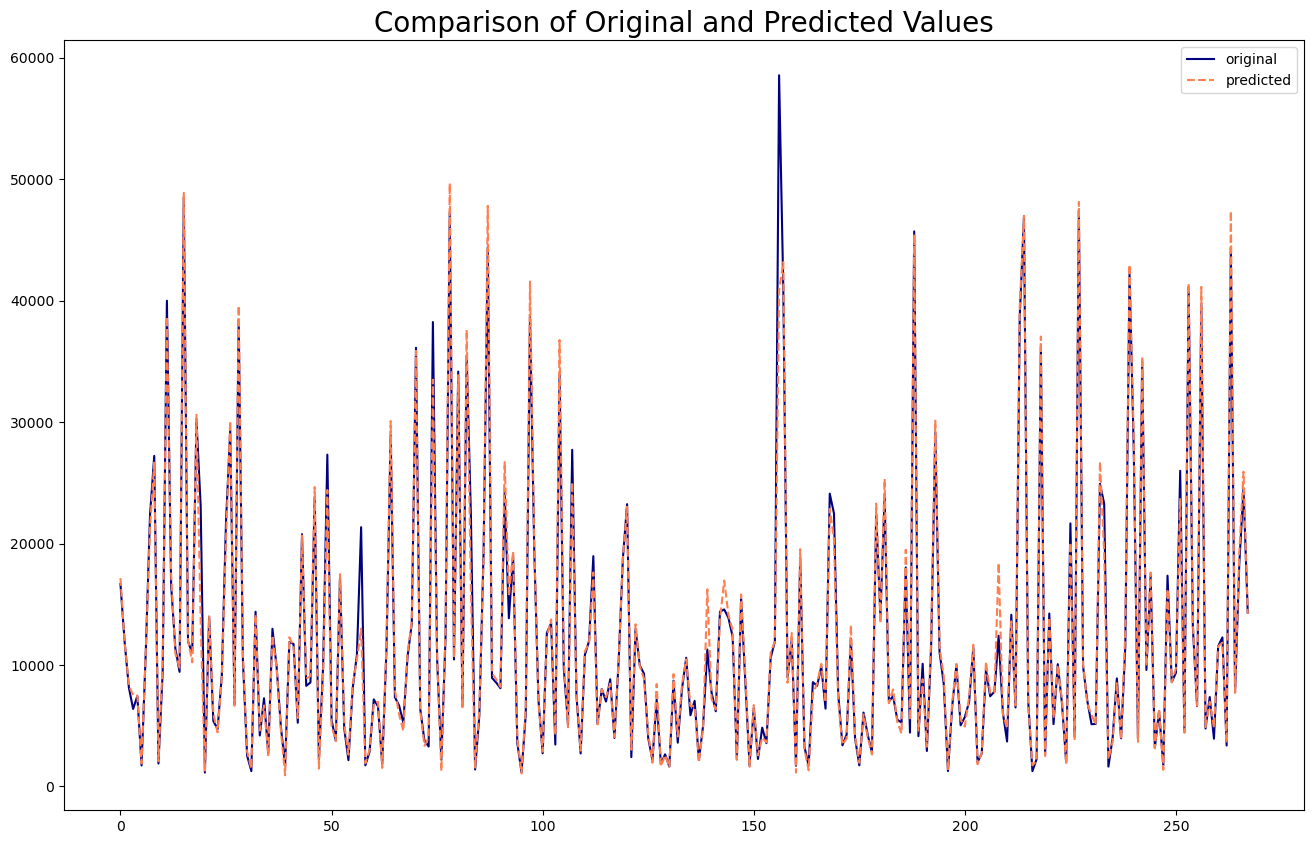

In [28]:
#Plot an overlap between original and predicted values
ax = range(len(y_test))
plt.figure(figsize=(16,10))
plt.plot(ax, y_test, label='original', color='navy')
plt.plot(ax, test_pred, label='predicted', color='coral', linestyle='--')
plt.title('Comparison of Original and Predicted Values', fontsize=20)
plt.legend()
plt.savefig('orig_preds_rf', dpi=400)
plt.show()

**Analysis:** The plot indicates a good overlapping representation with some outliers in the original dataset that could be further analyzed in the future analysis.

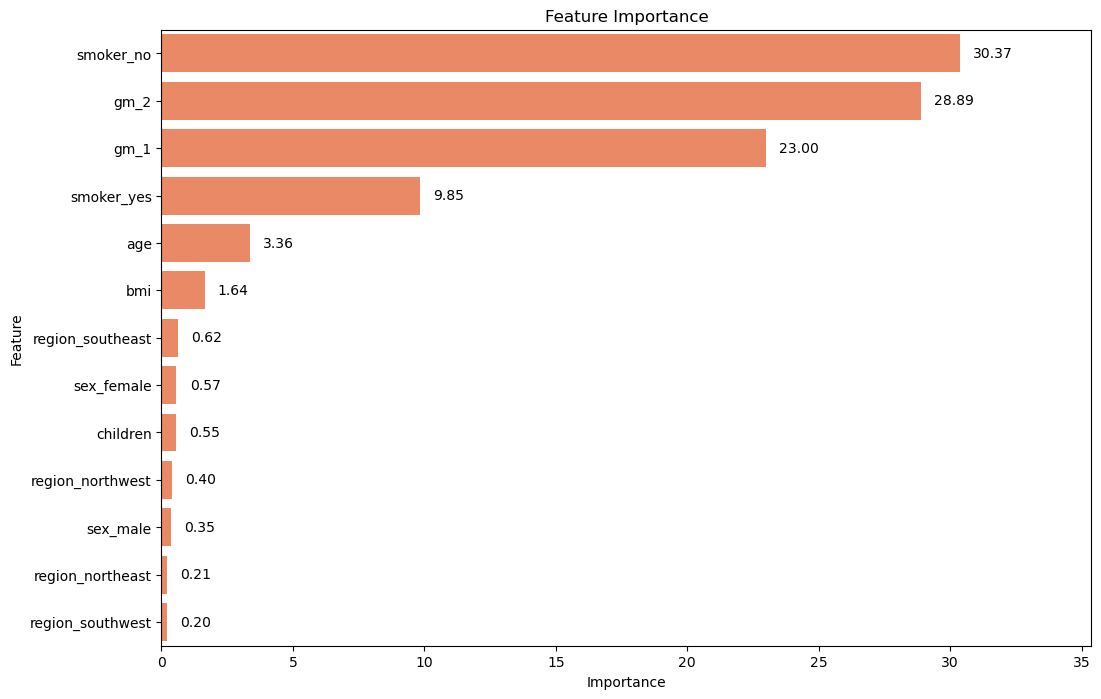

In [29]:
#To identify the key features that are identified by this model
feature_importance = xgb_best_model.feature_importances_ * 100
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Importance', y='Feature', data=feature_importance, color='coral')
plt.xlim(0, feature_importance['Importance'].max() + 5)
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value + 0.5, index, f'{value:.2f}', color='black', ha='left', va='center')
plt.title('Feature Importance')
plt.savefig('feature_imp_rf', dpi=400)
plt.show()

**Analysis:** The plot indicates a significant impact of Gaussian Mixture Cluster GM_1 and GM_2 followed by smoker and age as key variables impacting the overall insurance.

<font size=5><p style="color:black"> RandomForest Analysis

In [30]:
rf_param_grid = {
    'n_estimators': [10, 200, 500], 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 10, 15, 20],  
    'max_leaf_nodes': [None, 5, 10, 20],  
}

rf_reg = RandomForestRegressor()

randomized_neg_mse = RandomizedSearchCV(estimator=rf_reg, param_distributions=rf_param_grid, n_iter=100, scoring='neg_mean_squared_error',
                                        cv=4, verbose=1, random_state=42, n_jobs=-1)

randomized_neg_mse.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [None, 5, 10, 20],
                                        'n_estimators': [10, 200, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [31]:
rf_best_params = randomized_neg_mse.best_params_
rf_best_score = randomized_neg_mse.best_score_
rf_best_model = randomized_neg_mse.best_estimator_

print('Best parameters found: ', rf_best_params)
print('Lowest RMSE found: ', np.sqrt(np.abs(rf_best_score)))

Best parameters found:  {'n_estimators': 500, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 15}
Lowest RMSE found:  2116.2201140981674


### Cross Validation with best params

In [32]:
rf_best_model_cv = RandomForestRegressor(**rf_best_params)
rf_cv = cross_val_score(rf_best_model_cv, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
rf_cv_rmse = np.sqrt(-rf_cv)

print('Average RMSE on cross-validation: %.2f' % rf_cv_rmse.mean())

Average RMSE on cross-validation: 1976.92


<font size=5><p style="color:black"> Best Params Prediction (RFTreeRegressor)

In [33]:
rf_best_model.fit(X_train, y_train)
train_pred = rf_best_model.predict(X_train)
print('Root mean squared error =', mean_squared_error(y_train, train_pred, squared=False))
print('R squared =', r2_score(y_train, train_pred))

Root mean squared error = 758.5507164234697
R squared = 0.9962008238873696


In [34]:
test_pred = rf_best_model.predict(X_test)
print('Root mean squared error (Test) =', mean_squared_error(y_test, test_pred, squared=False))
print('R squared =', r2_score(y_test, test_pred))

Root mean squared error (Test) = 1845.0137831456104
R squared = 0.9728934082340509


**Analysis:** The training dataset gave us a RMSE of 795.76 and R2 of 0.995. The test dataset gave us a RMSE of 1950.61 with an R2 of 0.969. This indicates strong overfitting.

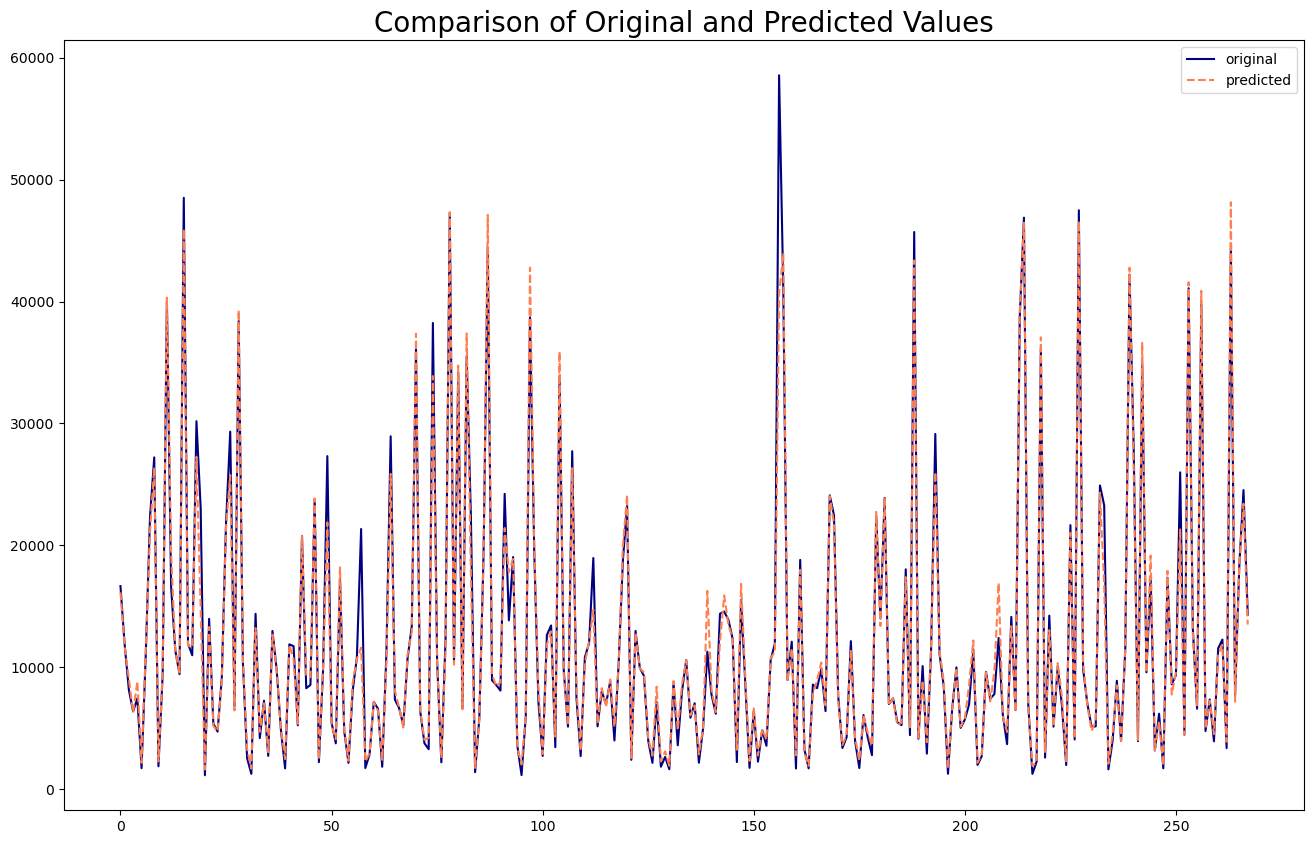

In [35]:
#Create a plot to compare original and predicted values
ax = range(len(y_test))
plt.figure(figsize=(16,10))
plt.plot(ax, y_test, label='original', color='navy')
plt.plot(ax, test_pred, label='predicted', color='coral', linestyle='--')
plt.title('Comparison of Original and Predicted Values', fontsize=20)
plt.legend()
plt.savefig('orig_preds_rf', dpi=400)
plt.show()

**Analysis:** The plot indicates a good overlapping representation with some outliers in the original dataset that could be further analyzed in the future analysis.

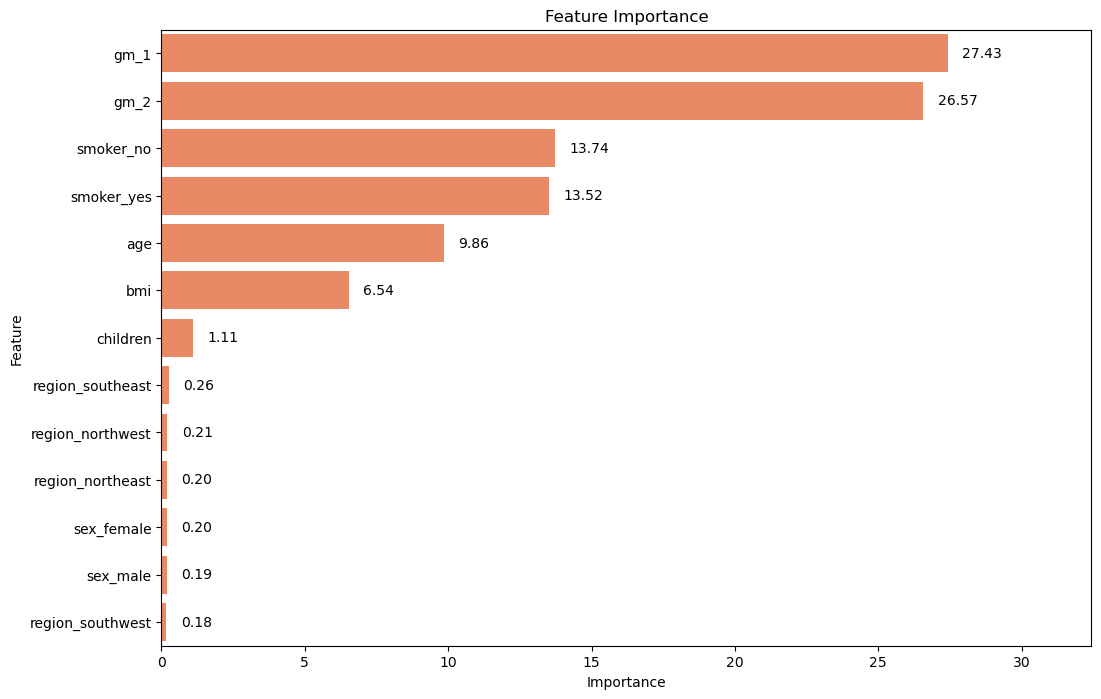

In [36]:
feature_importance = rf_best_model.feature_importances_ * 100
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Importance', y='Feature', data=feature_importance, color='coral')
plt.xlim(0, feature_importance['Importance'].max() + 5)
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value + 0.5, index, f'{value:.2f}', color='black', ha='left', va='center')
plt.title('Feature Importance')
plt.savefig('feature_imp_rf', dpi=400)
plt.show()

**Analysis:** The plot indicates a significant impact of Gaussian Mixture Cluster GM_1, followed by smoker status, GM_2, age and BMI as key variables impacting the overall insurance.

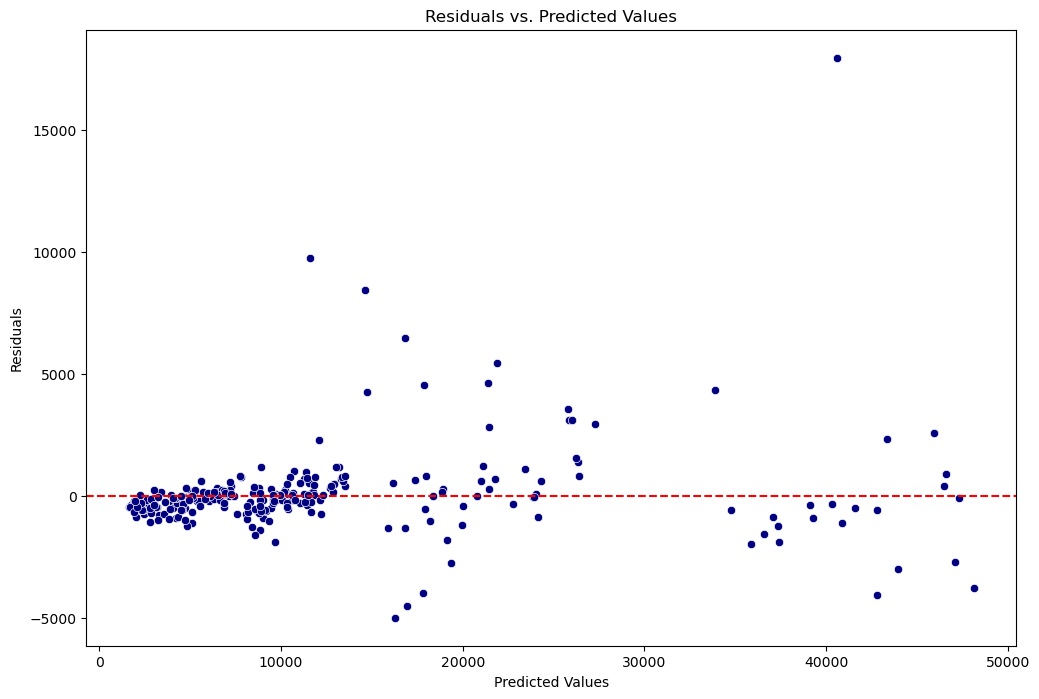

In [37]:
#Residual Plot
residuals = y_test - test_pred
plt.figure(figsize=(12, 8))
sns.scatterplot(x=test_pred, y=residuals, color='navy')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig('residuals_preds', dpi=400)
plt.show()

&emsp;**Analysis:** The residual plot indicates a strong correlation with various clusters with more correlation at a range below 15,000 and virtually no correlation at higher values. The red dashed line at zero represents the ideal scenario where residuals are nonexistent, meaning the model's predictions perfectly match the actual values. The closer the residuals are to zero, the better the model's predictive performance.

Most of the data points cluster around the red horizontal line, indicating that the model generally provides accurate predictions.
Outliers: A few points exhibit large positive residuals, suggesting that in certain cases, the model significantly underestimates the actual values.

At first glance, the residuals appear to be randomly scattered, which is a positive sign. This suggests that the model adequately captures the data's underlying patterns without evident systematic errors.

Overall, this residual plot paints a promising picture of our model's performance. While there's room for improvement in handling those underestimated values, the overall random distribution of residuals indicates a good fit to the data.

# Final Results and Conclusion<a id='final-results'></a>

In [38]:
# specify the Column Names while initializing the Table 
table = PrettyTable(["Model Name", "RMSE Score", "R2 Score"]) 

# add rows 
table.add_row(["Linear Regression", "2146.59", "0.969"]) 
table.add_row(["Ridge Regression", "2149.52", "0.969"]) 
table.add_row(["Lasso Regression", "2146.59", "0.969"])
table.add_row(["ElasticNet Regression", "2691.45", "0.952"])
table.add_row(["XGBoost Regression", "1276.37", "0.989"])
table.add_row(["Random Forest Regression", "736.99", "0.996"]) 
table.add_row(["Gradient Boost Regression", "1401.62", "0.987"]) 
table.add_row(["**XGBoost Regression (Hyperparameter Tuning)", "1288.37", "0.989"])
table.add_row(["**RFBoost Regression (Hyperparameter Tuning)", "795.07", "0.995"])

print(table)

+----------------------------------------------+------------+----------+
|                  Model Name                  | RMSE Score | R2 Score |
+----------------------------------------------+------------+----------+
|              Linear Regression               |  2146.59   |  0.969   |
|               Ridge Regression               |  2149.52   |  0.969   |
|               Lasso Regression               |  2146.59   |  0.969   |
|            ElasticNet Regression             |  2691.45   |  0.952   |
|              XGBoost Regression              |  1276.37   |  0.989   |
|           Random Forest Regression           |   736.99   |  0.996   |
|          Gradient Boost Regression           |  1401.62   |  0.987   |
| **XGBoost Regression (Hyperparameter Tuning) |  1288.37   |  0.989   |
| **RFBoost Regression (Hyperparameter Tuning) |   795.07   |  0.995   |
+----------------------------------------------+------------+----------+


Root mean squared error = 1845.0137831456104
R squared = 0.9728934082340509


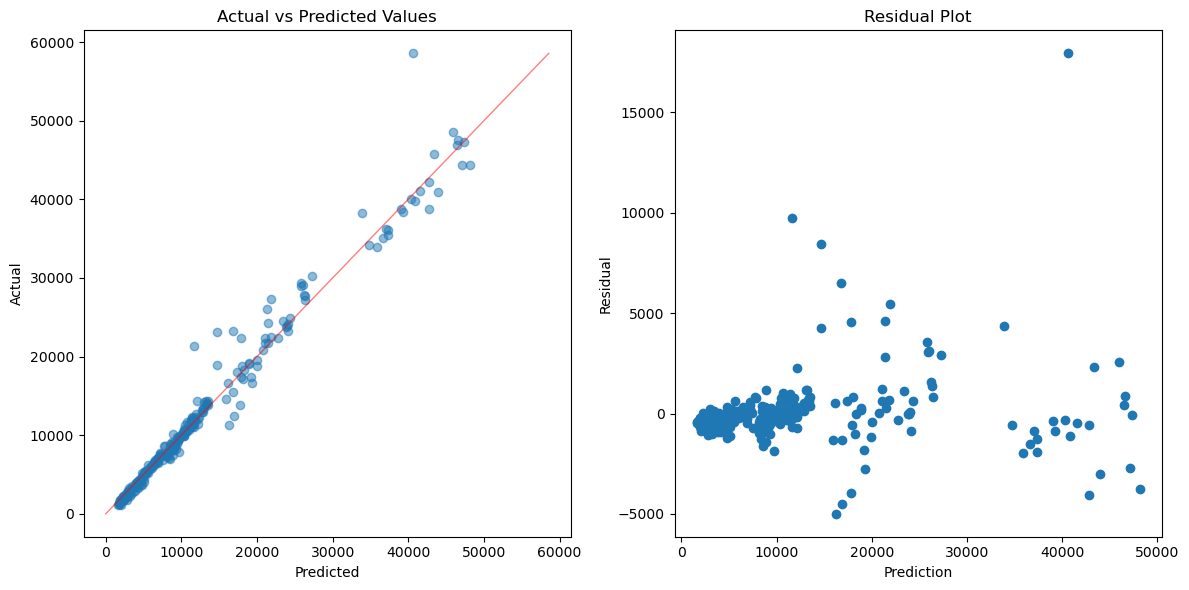

In [39]:
# Evaluate with test data
test_pred = rf_best_model.predict(X_test)
print('Root mean squared error =', mean_squared_error(y_test, test_pred, squared=False))
print('R squared =', r2_score(y_test, test_pred))

# Visualize accuracy and residuals
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].scatter(test_pred, y_test, alpha=.5)
axes[0].plot([0,y_test.max()],[0,y_test.max()], lw=1, color='red', alpha=.5)
axes[0].set_ylabel("Actual")
axes[0].set_xlabel("Predicted")
axes[0].set_title("Actual vs Predicted Values")

residuals = y_test - test_pred
axes[1].scatter(test_pred, residuals)
axes[1].set_xlabel("Prediction")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residual Plot")

fig.tight_layout()
plt.show()

&emsp;**Conclusion:**  

&emsp;As shown in the Actual vs Predicted Values plot, the model seems to be able to accurately predict values in the low range of medical cost. This could be explained by sampling error which its sign is also shown and partially explained in the [scatterplot](#charges-age) previously which shows 3 separated trendlines. The bottom trendline is much denser than other two. Although all the trendlines gradually go up with age, the amount of medical cost differs. The potential reason to this could be explained by wealth of the people or their choices of medical expenditure allocation. Private hospital usually charges much more than the public hospitals. The trendlines could be explained by the type of hospital or services the people choose to receive.  

# Findings<a id='findings'></a>
In this project, we conducted exploratory data analysis and compared Linear Regression, Lasso Regression, Ridge Regression, ElasticNet Regression, XGBoost Regression, Random Forest and Gradien Boost Regression to identify the key attributes affecting premium charges. 

Our best prediction performance was achieved using Random Forest Tree Regression Model with Hyperparameter Tuning. The model was able to achieve a RMSE of 795.07 and R2 Score of 0.995.

## Top Factors
Based on our modeling results, the top 4 attributes influencing premium charges are:

- Smoker: Whether the insured is a smoker or not.
- Age: The age of the insured.
- Children: The number of children.
- BMI: Body Mass Index.

## Smoker's Premium Charge
For smokers, the price of their premium primarily depends on the interaction between their BMI and age. Smokers with an obese BMI tend to face higher premium charges.

## Non-smoker's Premium Charge
Non-smokers’ premium charges are mainly influenced by their age, number of children, and BMI. Individuals in their early 20s with no children and a BMI within the healthy to overweight range have the lowest premium prices. As insured individuals age or have more children, the insurance premium increases.

## Quantifying the Effects
To quantify the effects of these attributes on premium charges, we can refer to the plot generated by our model that indicates strong correlation and results upto 15,000 USD. Beyond 15,000 USD, the outliers impact the overall results.

## Recommendations
In this straightforward project, we identified and quantified the impact of key factors on premium charges. For smokers seeking health insurance, we recommend developing a plan to quit smoking, maintaining a healthy diet, and exercising to keep their BMI within the healthy range—ultimately leading to lower insurance premiums. Non-smokers aiming for lower premiums should start early and focus on maintaining a healthy BMI.

# Reference<a id='reference'></a>
https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset